# **MOVIE REVIEWS SENTIMENT ANALYSIS**
---
---

---
### **IMPORT LIBRARIES AND OTHER DEPENDENCIES**
---

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import spacy

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

---
---

### **DATA WRANGLING** 
---
---

---
### DATA GATHERING
---

In [2]:
df = pd.read_csv('train.csv')
df.head()

,reviews_content,category
0,airplane ! is considered among many to be the ...,positive
1,you've got to love disney . \nno matter what t...,positive
2,""" the tailor of panama "" is a different kind ...",positive
3,"the characters in jonathan lynn's "" the whole ...",negative
4,"vikings v . bears ? \nno , this isn't the line...",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviews_content  1500 non-null   object
 1   category         1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [4]:
df.describe()

,reviews_content,category
count,1500,1500
unique,1500,2
top,airplane ! is considered among many to be the ...,positive
freq,1,752


In [5]:
df.isna().sum()
print("Number of NaN data in column", df.isnull().sum())

Number of NaN data in column reviews_content    0
category           0
dtype: int64


In [6]:
df.isnull().sum()
print("Number of null data in column", df.isnull().sum())


Number of null data in column reviews_content    0
category           0
dtype: int64


In [7]:
df.duplicated().sum()
print("Number of duplicated data within the dataset is", df.duplicated().sum())

Number of duplicated data within the dataset is 0


---

### PRE PROCESSING

---

#### Expanding Contractions

In [8]:
def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):
        expanded_contraction = contraction_mapping.get(contraction.group(0).lower())
        if not expanded_contraction:
            expanded_contraction = contraction_mapping.get(contraction.group(0).lower())
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    
    return expanded_text

contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "y'all": "you all",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}
preprocessed_df = df.copy()
preprocessed_df['reviews_content'] = df['reviews_content'].apply(lambda x: expand_contractions(x, contraction_mapping))

print("\nDataFrame after expanding contractions:")
preprocessed_df.head()



DataFrame after expanding contractions:


,reviews_content,category
0,airplane ! is considered among many to be the ...,positive
1,you have got to love disney . \nno matter what...,positive
2,""" the tailor of panama "" is a different kind ...",positive
3,"the characters in jonathan lynn's "" the whole ...",negative
4,"vikings v . bears ? \nno , this is not the lin...",negative


#### Lowercasing, Removing Stop Words, And Tokenizing

After some tests, Dataset with non alphabetical character gives much higher accuracy than without.

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def CleanText(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)

    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

preprocessed_df['reviews_content'] = preprocessed_df['reviews_content'].apply(CleanText)
preprocessed_df['reviews_content'].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ferroyudisthira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [airplane, !, considered, among, many, epitome...
1    [got, love, disney, ., matter, serve, ,, guara...
2    [``, tailor, panama, ``, different, kind, spy,...
3    [characters, jonathan, lynn, 's, ``, whole, ni...
4    [vikings, v, ., bears, ?, ,, lineup, monday, n...
Name: reviews_content, dtype: object

### Lemmatizer

Lemmatizer is needed to return words back to their root form

In [10]:
sp = spacy.load("en_core_web_sm")

def lemmatization(text_list):
    text = ' '.join(text_list)
    tokenized_text = sp(text)

    lemmatized_text = ' '.join([word.lemma_ for word in tokenized_text])
    return lemmatized_text


preprocessed_df['reviews_content'] = preprocessed_df['reviews_content'].apply(lemmatization)
preprocessed_df.head()

,reviews_content,category
0,airplane ! consider among many epitome satire ...,positive
1,"get love disney . matter serve , guarantee suc...",positive
2,` ` tailor panama ` ` different kind spy movie...,positive
3,character jonathan lynn 's ` ` whole nine yard...,negative
4,"viking v . bear ? , lineup monday night footba...",negative


---
---
### **FEATURE EXTRACTION**
---
---

### TF-IDF Method

Let's try to tune the TF-IDF parameter to find the feature extraction. I am using the LinearSVM model to generate the Accuracy score.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

min_df_range = range(1, 10)
max_df_range = [i / 10 for i in range(1, 10)]
max_features_range = range(1000, 15000, 1000)

best_accuracy = 0
best_params = {}

accuracy_scores = []

for min_df in min_df_range:
    for max_df in max_df_range:
        for max_features_val in max_features_range:
            tfidf_params = {
                'min_df': min_df,
                'max_df': max_df,
                'ngram_range': (1, 1),
                'max_features': max_features_val
            }

            tfidf_vectorizer = TfidfVectorizer(**tfidf_params)
            X = preprocessed_df['reviews_content']
            y = preprocessed_df['category']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21000002, random_state=42, stratify=y)

            X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
            X_test_tfidf = tfidf_vectorizer.transform(X_test)

            svm_model = LinearSVC(dual='auto')
            svm_model.fit(X_train_tfidf, y_train)

            y_pred_tuned = svm_model.predict(X_test_tfidf)

            accuracy = accuracy_score(y_test, y_pred_tuned)
            accuracy_scores.append(accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'min_df': min_df,
                    'max_df': max_df,
                    'max_features': max_features_val
                }

print("Best accuracy:", best_accuracy)
print("Best parameters:", best_params)


Best accuracy: 0.8670886075949367
Best parameters: {'min_df': 3, 'max_df': 0.9, 'max_features': 4000}


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2100002, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.9, max_features=4000, ngram_range=(1,1))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

---
---

### **Creating Model**

---
---

---
#### Linear SVM Model
---

##### Base TF-IDF

In [13]:
svm_model = LinearSVC(dual='auto')
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_svm)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Linear SVM Accuracy: 0.8670886075949367
Linear SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       158
    positive       0.87      0.87      0.87       158

    accuracy                           0.87       316
   macro avg       0.87      0.87      0.87       316
weighted avg       0.87      0.87      0.87       316



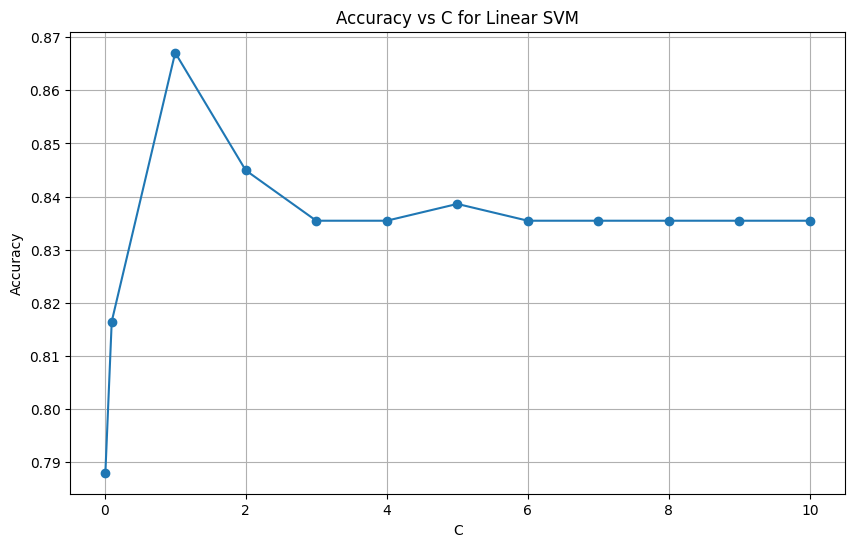

Best C value: 1
Tuned Linear SVM Accuracy: 0.8670886075949367
Tuned Linear SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       158
    positive       0.87      0.87      0.87       158

    accuracy                           0.87       316
   macro avg       0.87      0.87      0.87       316
weighted avg       0.87      0.87      0.87       316



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Define the values of C to search
C_values = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracies = []

for C in C_values:
    # Initialize and train the LinearSVC model with the current C value
    svm_model = LinearSVC(dual='auto', C=C)
    svm_model.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if this C value gives better accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for Linear SVM')
plt.grid(True)
plt.show()

# Find the best C value that gives the highest accuracy
best_accuracy = max(accuracies)
best_C = C_values[accuracies.index(best_accuracy)]

# Train a new model using the best C value
svm_model_tuned = LinearSVC(dual='auto', C=best_C)
svm_model_tuned.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svm_tuned = svm_model_tuned.predict(X_test_tfidf)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_svm_tuned)
print("Best C value:", best_C)
print("Tuned Linear SVM Accuracy:", accuracy_tuned)
print("Tuned Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm_tuned))


---
### SVC Kernel Based Model
---

---
#### Polynomial Kernel
---

##### Base TF-IDF

In [15]:
svc_poly_model = SVC(kernel='poly')

# Fit the model on the training data
svc_poly_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_poly = svc_poly_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print("SVC with Polynomial Kernel Accuracy:", accuracy_poly)

print("\nSVC with Polynomial Kernel Classification Report:")
print(classification_report(y_test, y_pred_poly))

SVC with Polynomial Kernel Accuracy: 0.7246835443037974

SVC with Polynomial Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.73      0.73       158
    positive       0.73      0.72      0.72       158

    accuracy                           0.72       316
   macro avg       0.72      0.72      0.72       316
weighted avg       0.72      0.72      0.72       316



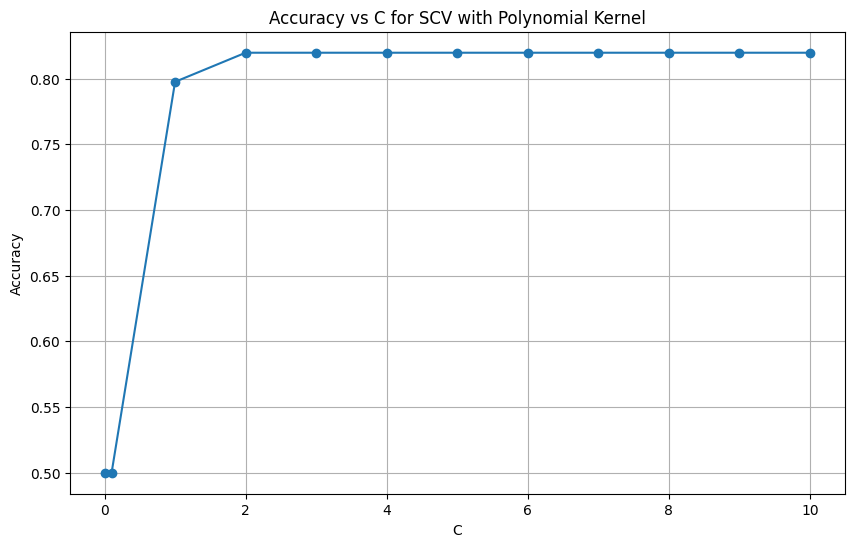

Best C value: 2
Tuned SCV with Polynomial Kernel Accuracy: 0.819620253164557
Tuned SCV with Polynomial Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82       158
    positive       0.81      0.83      0.82       158

    accuracy                           0.82       316
   macro avg       0.82      0.82      0.82       316
weighted avg       0.82      0.82      0.82       316



In [16]:
C_values = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracies = []

for C in C_values:
    # Initialize and train the LinearSVC model with the current C value
    svc_poly_tuned = SVC(kernel='poly', degree=2, gamma='scale',C=C)
    svc_poly_tuned.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = svc_poly_tuned.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if this C value gives better accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for SCV with Polynomial Kernel')
plt.grid(True)
plt.show()

# Find the best C value that gives the highest accuracy
best_accuracy = max(accuracies)
best_C = C_values[accuracies.index(best_accuracy)]

# Train a new model using the best C value
svc_poly_tuned = SVC(kernel='poly', degree=2, gamma='scale',C=best_C)
svc_poly_tuned.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_poly_tuned = svc_poly_tuned.predict(X_test_tfidf)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_poly_tuned)
print("Best C value:", best_C)
print("Tuned SCV with Polynomial Kernel Accuracy:", accuracy_tuned)
print("Tuned SCV with Polynomial Kernel Classification Report:")
print(classification_report(y_test, y_pred_poly_tuned))


---
#### Radial Basis Function (RBF) Kernel
---

##### Base TF-IDF

In [17]:
svc_rbf_model = SVC(kernel='rbf')

# Fit the model on the training data
svc_rbf_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_rbf = svc_rbf_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("SVC with RBF Kernel Accuracy:", accuracy_rbf)

print("\nSVC with RBF Kernel Classification Report:")
print(classification_report(y_test, y_pred_rbf))

SVC with RBF Kernel Accuracy: 0.8259493670886076

SVC with RBF Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.81      0.82       158
    positive       0.82      0.84      0.83       158

    accuracy                           0.83       316
   macro avg       0.83      0.83      0.83       316
weighted avg       0.83      0.83      0.83       316



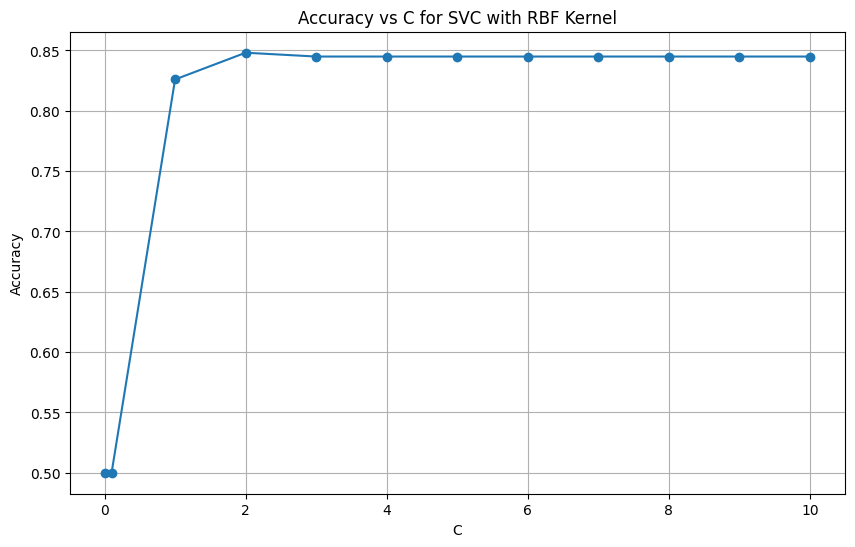

Best C value: 2
Tuned SVC with RBF Kernel Accuracy: 0.8481012658227848
Tuned SVC with RBF Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       158
    positive       0.85      0.85      0.85       158

    accuracy                           0.85       316
   macro avg       0.85      0.85      0.85       316
weighted avg       0.85      0.85      0.85       316



In [18]:
C_values = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracies = []

for C in C_values:
    # Initialize and train the LinearSVC model with the current C value
    svc_rbf_tuned = SVC(kernel='rbf', gamma='scale',C=C)
    svc_rbf_tuned.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = svc_rbf_tuned.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if this C value gives better accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for SVC with RBF Kernel')
plt.grid(True)
plt.show()

# Find the best C value that gives the highest accuracy
best_accuracy = max(accuracies)
best_C = C_values[accuracies.index(best_accuracy)]

# Train a new model using the best C value
svc_rbf_tuned = SVC(kernel='rbf', gamma='scale',C=best_C)
svc_rbf_tuned.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rbf_tuned = svc_rbf_tuned.predict(X_test_tfidf)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_rbf_tuned)
print("Best C value:", best_C)
print("Tuned SVC with RBF Kernel Accuracy:", accuracy_tuned)
print("Tuned SVC with RBF Kernel Classification Report:")
print(classification_report(y_test, y_pred_rbf_tuned))


---
#### Sigmoid Kernel
---

##### Base TF-IDF

In [19]:
svc_sig_model = SVC(kernel='sigmoid')

# Fit the model on the training data
svc_sig_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_sig = svc_sig_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_sig = accuracy_score(y_test, y_pred_sig)
print("SVC with Sigmoid Kernel Accuracy:", accuracy_sig)

print("\nSVC with Sigmoid Kernel Classification Report:")
print(classification_report(y_test, y_pred_sig))

SVC with Sigmoid Kernel Accuracy: 0.8575949367088608

SVC with Sigmoid Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       158
    positive       0.85      0.87      0.86       158

    accuracy                           0.86       316
   macro avg       0.86      0.86      0.86       316
weighted avg       0.86      0.86      0.86       316



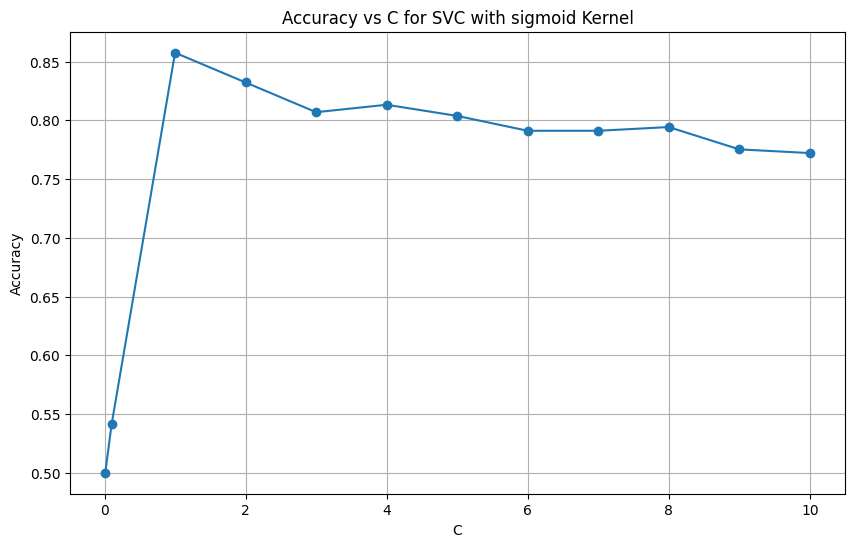

Best C value: 1
Tuned SVC with RBF Kernel Accuracy: 0.8575949367088608
Tuned SVC with RBF Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       158
    positive       0.85      0.87      0.86       158

    accuracy                           0.86       316
   macro avg       0.86      0.86      0.86       316
weighted avg       0.86      0.86      0.86       316



In [20]:
C_values = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracies = []

for C in C_values:
    # Initialize and train the LinearSVC model with the current C value
    svc_sig_tuned = SVC(kernel='sigmoid', gamma='scale',C=C)
    svc_sig_tuned.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = svc_sig_tuned.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if this C value gives better accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for SVC with sigmoid Kernel')
plt.grid(True)
plt.show()

# Find the best C value that gives the highest accuracy
best_accuracy = max(accuracies)
best_C = C_values[accuracies.index(best_accuracy)]

# Train a new model using the best C value
svc_sig_tuned = SVC(kernel='sigmoid', gamma='scale',C=best_C)
svc_sig_tuned.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_sig_tuned = svc_sig_tuned.predict(X_test_tfidf)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_sig_tuned)
print("Best C value:", best_C)
print("Tuned SVC with RBF Kernel Accuracy:", accuracy_tuned)
print("Tuned SVC with RBF Kernel Classification Report:")
print(classification_report(y_test, y_pred_sig_tuned))


---
#### Linear Kernel
---

##### Base TF-IDF

In [21]:
svc_lin_model = SVC(kernel='linear')

# Fit the model on the training data
svc_lin_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_lin = svc_lin_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_lin = accuracy_score(y_test, y_pred_lin)
print("SVC with Linear Kernel Accuracy:", accuracy_lin)

print("\nSVC with Linear Kernel Classification Report:")
print(classification_report(y_test, y_pred_lin))

SVC with Linear Kernel Accuracy: 0.8575949367088608

SVC with Linear Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       158
    positive       0.85      0.87      0.86       158

    accuracy                           0.86       316
   macro avg       0.86      0.86      0.86       316
weighted avg       0.86      0.86      0.86       316



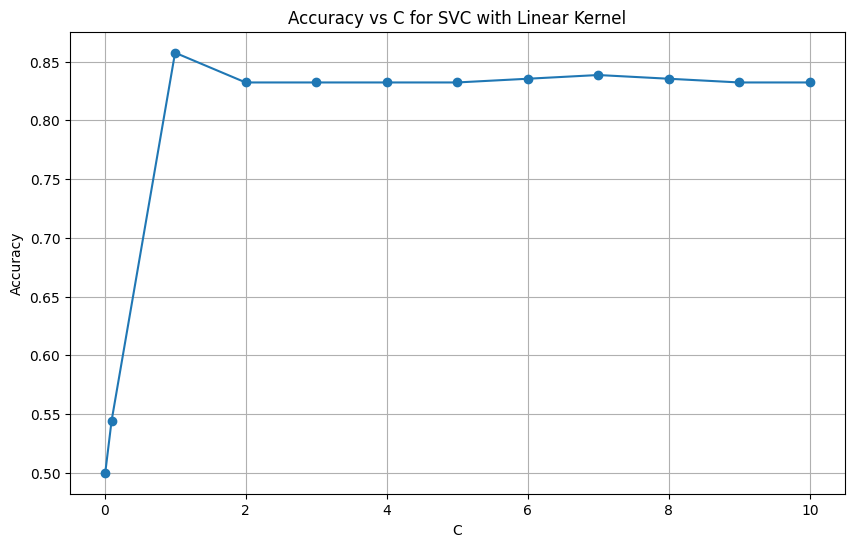

Best C value: 1
Tuned SVC with RBF Kernel Accuracy: 0.8575949367088608
Tuned SVC with RBF Kernel Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       158
    positive       0.85      0.87      0.86       158

    accuracy                           0.86       316
   macro avg       0.86      0.86      0.86       316
weighted avg       0.86      0.86      0.86       316



In [22]:
C_values = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracies = []

for C in C_values:
    # Initialize and train the LinearSVC model with the current C value
    svc_lin_tuned = SVC(kernel='linear',C=C)
    svc_lin_tuned.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = svc_lin_tuned.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Check if this C value gives better accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C for SVC with Linear Kernel')
plt.grid(True)
plt.show()

# Find the best C value that gives the highest accuracy
best_accuracy = max(accuracies)
best_C = C_values[accuracies.index(best_accuracy)]

# Train a new model using the best C value
svc_lin_tuned = SVC(kernel='linear', gamma='scale',C=best_C)
svc_lin_tuned.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lin_tuned = svc_sig_tuned.predict(X_test_tfidf)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_lin_tuned)
print("Best C value:", best_C)
print("Tuned SVC with RBF Kernel Accuracy:", accuracy_tuned)
print("Tuned SVC with RBF Kernel Classification Report:")
print(classification_report(y_test, y_pred_lin_tuned))


---
#### Ensamble Model
---

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create the voting ensemble
voting_classifier = VotingClassifier(
    estimators=[
        ('svm_linear', svm_model_tuned),
        ('svm_poly', svc_poly_tuned),
        ('svm_rbf', svc_rbf_tuned),
        ('svm_sigmoid', svc_sig_tuned),
        ('svm_linear_svc', svc_lin_tuned)
    ],
    voting='hard'  # Use 'hard' voting for majority rule
)

# Fit the voting ensemble on the training data
voting_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_voting = voting_classifier.predict(X_test_tfidf)

# Evaluate the voting ensemble
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Voting Ensemble Accuracy:", accuracy_voting)
print("Voting Ensemble Classification Report:")
print(classification_report(y_test, y_pred_voting))


Voting Ensemble Accuracy: 0.8639240506329114
Voting Ensemble Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.86      0.86       158
    positive       0.86      0.87      0.86       158

    accuracy                           0.86       316
   macro avg       0.86      0.86      0.86       316
weighted avg       0.86      0.86      0.86       316



---
---
### **FINAL RESULT**
---
---

In [24]:
print("Accuracy score for LinearSVM model tuned", accuracy_score(y_test, y_pred_svm_tuned))
print("Accuracy score for SVC with Polynomial Kernel model tuned", accuracy_score(y_test, y_pred_poly_tuned))
print("Accuracy score for SVC with RBF Kernel tuned", accuracy_score(y_test, y_pred_rbf_tuned))
print("Accuracy score for SVC with sigmoid Kernel tuned", accuracy_score(y_test, y_pred_sig_tuned))
print("Accuracy score for SVC with linear Kernel tuned", accuracy_score(y_test, y_pred_lin_tuned))
print("Accuracy score for Ensamble Model", accuracy_score(y_test, y_pred_voting))

Accuracy score for LinearSVM model tuned 0.8670886075949367
Accuracy score for SVC with Polynomial Kernel model tuned 0.819620253164557
Accuracy score for SVC with RBF Kernel tuned 0.8481012658227848
Accuracy score for SVC with sigmoid Kernel tuned 0.8575949367088608
Accuracy score for SVC with linear Kernel tuned 0.8575949367088608
Accuracy score for Ensamble Model 0.8639240506329114


---
---
#  **END OF CODE** 
---
---